In [0]:
%matplotlib inline
import pandas as pd


<img src="https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/header.png" alt="drawing"/>


A multi-channel electroencephalography (EEG) system enables a broad range of applications including neurotherapy, biofeedback, and brain computer interfacing. The dataset you will analyse is created with the [Emotiv EPOC+](https://www.emotiv.com/product/emotiv-epoc-14-channel-mobile-eeg).  

It has 14 EEG channels with names based on the International 10-20 locations: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4:

<br/>
<br/>
<center>
<img src="https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/EEG.png" alt="drawing" width="200"/>
<center/>
<br/>
<br/>


All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. 

The experiment was conducted on one person only. The duration of the measurement was around 117 seconds.

From the paper:

> *The experiment was carried out in a quiet room. During
the experiment, the proband was being videotaped. To prevent
artifacts, the proband was not aware of the exact start time
of the measurement. Instead, he was told to sit relaxed, look
straight to the camera, and change the eye state at free will.
Only additional constraint was that, accumulated over the
entire session, the duration of both eye states should be about
the same and that the individual intervals should vary greatly
in length (from eye blinking to longer stretches)...*

The eye state was detected via a camera during the EEG measurement and later added manually to the file after analyzing the video frames. 

A label '1' indicates the eye-closed and '0' the eye-open state.

(*Source: Oliver Roesler, Stuttgart, Germany*)

Let's load the train and test set:

In [0]:
trainset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_train.csv")

testset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_test.csv")

sample_submission = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/sample_submission.csv")


You will fit a model on the trainset and make predictions on the testset. 

To submit these predictions to Kaggle you need to write a .csv file with two columns: 
- `index` that matches the `index` column in the test set.
- `label` which is your prediction.

Here is an example predictions file for Kaggle:

In [15]:
trainset.head()

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4,label
0,4299.49,3997.44,4277.95,4116.92,4353.85,4623.08,4100.00,4623.59,4202.56,4229.23,4211.79,4278.97,4600.00,4369.23,1
1,4302.05,3985.64,4261.03,4129.74,4334.36,4615.38,4072.31,4585.64,4192.31,4225.13,4195.90,4283.08,4607.18,4358.46,0
2,4321.03,4015.90,4265.13,4122.56,4333.33,4613.33,4072.82,4602.05,4192.31,4223.08,4155.38,4286.15,4608.21,4371.79,0
3,4408.21,4104.10,4380.00,4232.31,4449.74,4750.26,4169.23,4731.28,4311.28,4352.31,4319.49,4388.21,4715.90,4464.10,0
4,4347.18,3975.38,4266.67,4102.56,4333.33,4617.95,4097.44,4612.82,4210.77,4240.51,4248.21,4313.33,4664.10,4411.79,1


In [16]:
testset.head()

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4,index
0,4296.41,4040.51,4253.33,4124.10,4341.54,4618.46,4075.38,4601.03,4183.59,4204.10,4197.44,4268.72,4598.46,4342.56,0
1,4291.28,3994.36,4247.18,4102.56,4328.21,4616.41,4057.44,4622.56,4198.46,4227.69,4190.77,4260.51,4593.33,4337.95,1
2,4299.49,4019.49,4269.74,4116.41,4344.10,4635.38,4067.18,4627.18,4211.28,4233.33,4202.56,4280.51,4596.92,4350.26,2
3,4280.00,4004.62,4263.59,4120.51,4323.59,4603.08,4040.51,4589.23,4174.87,4212.82,4192.82,4271.79,4608.72,4344.10,3
4,4317.44,3968.72,4260.51,4101.54,4341.54,4600.51,4071.28,4607.69,4191.28,4231.28,4199.49,4282.05,4592.31,4372.82,4


In [17]:
sample_submission.head(10)

,index,label
0,0,0.168801
1,1,0.124169
2,2,0.947757
3,3,0.069585
4,4,0.635325
5,5,0.659027
6,6,0.653697
7,7,0.850030
8,8,0.160489
9,9,0.843272


Make sure to save your results without the extra Pandas index column that is written by default:

In [0]:
filename = "my_prediction_results.csv"

#make sure to not write the Pandas index column (index=False)
sample_submission.to_csv(filename,index=False)

Notice that this predictions file is saved on the cloud server machine. To download this file to your local machine you need to click the "Files" icon that you find in the sidebar on the left.

Submit this file to the [Kaggle competition website](https://www.kaggle.com/t/09885716fbf14eb08cc1cee2c9ebe7cc) to get an evaluation of your predictions on the public leaderboard.

For the report I want you to write a notebook with a scientific description of your analysis. You have to compare the prediction performance of your two best prediction models. This includes data pre-processing, hyperparameter tuning and model evaluation. I also want you to compare the actual predictions made by each model.

To create a new notebook go the "File" in the menu bar and click "New notebook". Do not forget to save your notebook to your GitHub account. You can create as many notebook as you want, but the final report should be in a notebook with the name "Kaggle_eye_blinking_prediciton.ipynb"

You will be evaluated (equal points) on clarity of the report, scientific insight and complexity of the analysis. 

**1.Pre-processing**

In this step we try to transform the feature values by removing the mean value and dividing it by their standard deviation. Otherwise features with big variance bigger than other might suppress the others in the background and make sit difficult for the estimator to learn correctly from other features.

In [0]:
trainset_copy = trainset.copy()
testset_copy = testset.copy()
label_column = trainset.pop('label')
index_column = testset.pop('index')

In [0]:
from sklearn.preprocessing import StandardScaler #pre-processing step where we center all the feature values around O
import matplotlib.pyplot as plt
import numpy as np


scaler = StandardScaler()
scaler.fit(trainset)
trainset_scaled = scaler.transform(trainset)
testset_scaled = scaler.transform(testset)

In [0]:
trainset_scaled= pd.DataFrame(data=trainset_scaled)
testset_scaled = pd.DataFrame(data=testset_scaled)

I plotted the labels to visualize their count, because in order to work with KNeighborclassifier they have to appear in an average equal amount otherwise the classifier might always favorise one class.

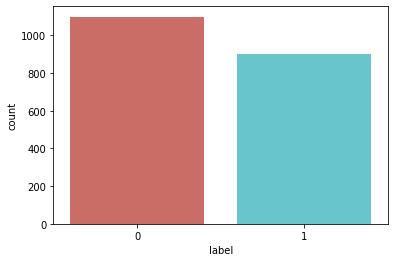

In [22]:
import seaborn as sns
sns.countplot(x='label', data=trainset_copy,palette='hls')
plt.show() # Plotting the ratio of the labels, because it might influence the KNeighbormodel fitting if the dataset consist mostly of one label;

The KNN classifier gets fitted on the training data 

# 2.KNeighborsClassifier

KNeighborsClassifier works with a hyperparameter K, a neighbor value that assigns how many neighbors the new data point will be compared to in order to be classified. By applying GridsearchCV we can obtain what the optimal K is in this instance. This classifier memorizes the labels of the training data and will try link the new data point to closest label. If one data point is mislabelled and K=1 this means that unseen data points will only rely on one point and be labelled as such. 

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier # hypertuning in finding the optimal n_neighbor value

#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=10)
#fit model to data
knn_gscv.fit(trainset_scaled, label_column)
knn_gscv.best_params_

{'n_neighbors': 1}

In [24]:
#KNeighboring model 

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)# classifier should be looking for the 1 nearest neighbor
knn.fit(trainset_scaled, label_column)#knn is fitted on features and response of training dataset

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

After fitting the model on trainingset, we can then fit it on the testdata and make predictions about. In this case I implemented the predict function that predicted for each index of the test data the label value.

In [25]:
knn.predict(testset_scaled)#After making a model with training data, next step is to fit the model on unseen data(test)


array([0, 1, 0, ..., 1, 1, 0])

# 3.Support Vector Machine
SVM works with a hyperplane in N-dimensions(N= amount of features). We had 14 features that contributed to the labelling of all the observations. SVM will classify training data by a hyperplane that is specified by support vectors because these data points decide where the boundary should be set and are closest to the decision plane.  In svm we want to find a hyperplane that is as far from one class as the other, creating a maximal margin that cleary sets a boundary between the classes.  

In case of a data that is linearly non separable we can use the kernel function radial basis function 'rbf'. This kernel can separate data points by transforming the vectors in higher dimension. In the RBF kernel there a two parameters that need to be tuned in order to optimize the generalization performance of our model. The fist parameter is Gamma, that determines how far the data points need to be in order to participate in making a decision boundary. A high gamma will only select support vectors because these points lay closer to the hyperplane, while as a lower gamma would take further laying training data into the model fitting. As for C , the penalty value for misclassification when overfitting the training data. A high C value will penalize our model for each misclassified point in away that the classifier will want to avoid this and starts to overfit the training data and perform less on unseen data.

For model tuning I computed via GridsearchCV the values for the hyperparameters gamma and C.

In [26]:
#SVM 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV # tried the gridsearch for C and gamma value

c_value = [0.001,0.01,0.1,1,10,100]
gamma_value = [0.001,0.01,0.1,1,10,100]
clf = svm.SVC() #estimator
params = dict(C=c_value, gamma=gamma_value )# grid of parameters you want to search the optimal value
grid_search = GridSearchCV(clf, param_grid=params, cv=10)
grid_search.fit(trainset_scaled, label_column)

print(grid_search.best_params_)

{'C': 10, 'gamma': 1}


In [27]:
clf = svm.SVC(C= 10, kernel='rbf',gamma=1, probability=True) 
 #gamma scales the influence two observations have on each other depending on the distance
clf.fit(trainset_scaled, label_column)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [28]:
clf.predict_proba(testset_scaled)

array([[0.99676376, 0.00323624],
       [0.63386273, 0.36613727],
       [0.99350001, 0.00649999],
       ...,
       [0.10807878, 0.89192122],
       [0.04935172, 0.95064828],
       [0.99546703, 0.00453297]])

Two models were used so we can eventually compare their prediction with true value of training data. In this part ROC curve will be plotted to show the prediction performance of the estimators of KNN and SVM algorithms. The scaled trainset will be splitted in 80% training dataset and 20% as test to evaluate the estimators performance on unseen data. I used a randomstate value of 4 so that the split function would generate each time the same results

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# shuffle and split training and into subset of train and test data
X_train, X_test, y_train, y_test = train_test_split(trainset_scaled, label_column, test_size=.2,
                                                    random_state=4)

In [0]:
clf = svm.SVC(C= 10, kernel='rbf',gamma=1, probability=True) 
 #gamma scales the influence two observations have on each other depending on the distance
clf.fit(X_train, y_train)
svm_predict = clf.decision_function(X_test)

In [44]:
knn = KNeighborsClassifier(n_neighbors=1)# classifier should be looking for the 1 nearest neighbor
knn.fit(X_train, y_train)
Knn_predict = knn.predict(X_test)
print(Knn_predict)

[0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1
 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1
 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0
 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0
 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0
 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1
 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0
 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0
 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0]


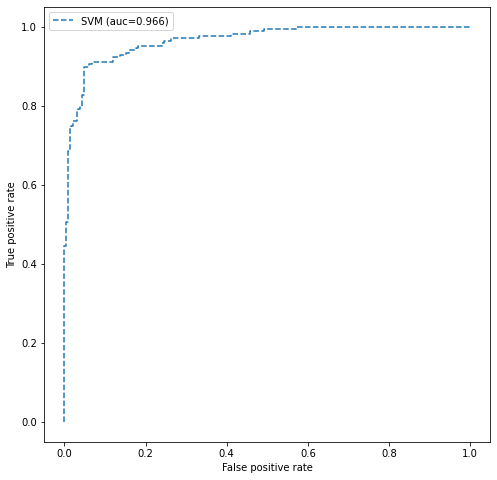

In [40]:
#Plotting ROC and compare the AUC of the classifiers
#Knn_fpr, Knn_tpr, threshold = roc_curve(y_test,Knn_predict) # ROC curve of KNN
#Knn_auc = auc(Knn_fpr, Knn_tpr) 

svm_fpr, svm_tpr, threshold = roc_curve(y_test,svm_predict) # ROC curve of SVM
svm_auc = auc(svm_fpr, svm_tpr)

plt.figure(figsize=(8,8))
#plt.plot(Knn_fpr, Knn_tpr, linestyle='-', label='KNN (auc=%0.3f)'% Knn_auc)
plt.plot(svm_fpr, svm_tpr, linestyle='--', label='SVM (auc=%0.3f)'% svm_auc)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

# Conclusions

I was not able to plot the ROC of KNN since it doesn' make predictions in probability values,but only classifies unseen data based on the neighbor(class) that occurs the most. With Support vector machine we obtained an AUC of 0,96 indicating that the classifier would able to classify observations in their true category minimizing misclassification.